In [1]:
from os import putenv
putenv("TF_XLA_FLAGS", "--tf_xla_enable_xla_devices=false")
putenv("CUDA_VISIBLE_DEVICES", "-1")

In [2]:
from tensorflow.keras import datasets, models, layers
#from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense, Flatten
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd

2024-12-31 15:40:30.388211: E external/local_xla/xla/stream_executor/plugin_registry.cc:91] Invalid plugin kind specified: FFT
2024-12-31 15:40:30.429803: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-31 15:40:30.837887: E external/local_xla/xla/stream_executor/plugin_registry.cc:91] Invalid plugin kind specified: DNN


In [3]:
tf.__version__

'2.16.1'

In [4]:
%load_ext tensorboard

In [5]:
logdir='log'

In [6]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))
train_images, test_images = train_images / 255.0, test_images / 255.0
classes=[0,1,2,3,4,5,6,7,8,9]

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=((28,28,1))))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

/home/rodrigoandrigo/Notebooks/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-31 15:40:33.015161: E external/local_xla/xla/stream_executor/rocm/rocm_driver.cc:301] failed call to hipInit: HIP_ERROR_NoDevice
2024-12-31 15:40:33.015185: I external/local_xla/xla/stream_executor/rocm/rocm_diagnostics.cc:110] retrieving ROCM diagnostic information for host: rodrigo1
2024-12-31 15:40:33.015192: I external/local_xla/xla/stream_executor/rocm/rocm_diagnostics.cc:117] hostname: rodrigo1
2024-12-31 15:40:33.015256: I external/local_xla/xla/stream_executor/rocm/rocm_diagnostics.cc:140] librocm reported version is: NOT_FOUND: was unable to find librocm.so DSO loaded into this program
2024-12-31 15:40:33.

In [8]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [9]:
model.compile(optimizer='adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.fit(x=train_images, y=train_labels, epochs=5, validation_data=(test_images,test_labels))

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.8898 - loss: 0.3495 - val_accuracy: 0.9808 - val_loss: 0.0578
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.9855 - loss: 0.0473 - val_accuracy: 0.9901 - val_loss: 0.0322
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9890 - loss: 0.0339 - val_accuracy: 0.9907 - val_loss: 0.0288
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9927 - loss: 0.0245 - val_accuracy: 0.9913 - val_loss: 0.0303
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9939 - loss: 0.0187 - val_accuracy: 0.9928 - val_loss: 0.0259


In [11]:
y_true=test_labels
#y_pred=model.predict(test_images)
y_pred = np.argmax(model.predict(test_images),axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [12]:
classes=[0,1,2,3,4,5,6,7,8,9]

In [13]:
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float')/con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

In [14]:
con_mat_df=pd.DataFrame(con_mat_norm, index=classes, columns=classes)

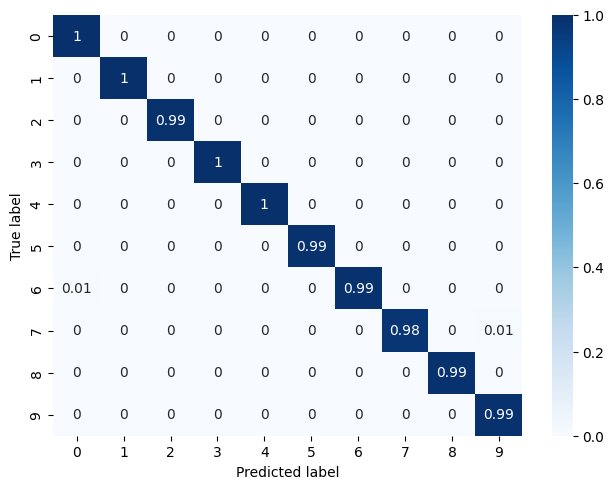

In [15]:
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [16]:
# Cálculo dos Verdadeiros Positivos, Falsos Positivos, Falsos Negativos e Verdadeiros Negativos
VP = np.diag(con_mat_norm)
FN = np.sum(con_mat_norm, axis=1) - VP
FP = np.sum(con_mat_norm, axis=0) - VP
VN = np.sum(con_mat_norm) - (VP + FN + FP)


In [17]:
# Funções para Sensibilidade, Especificidade, Acurácia, Precisão e F-score
sensibilidade = VP / (VP + FN)
especificidade = VN / (VN + FP)
acuracia = (VP + VN) / np.sum(con_mat_norm)
precisao = VP / (VP + FP)
f_score = 2 * (precisao * sensibilidade) / (precisao + sensibilidade)

In [18]:
print('A acuraria media foi de',acuracia.mean())

A acuraria media foi de 0.9995979899497487


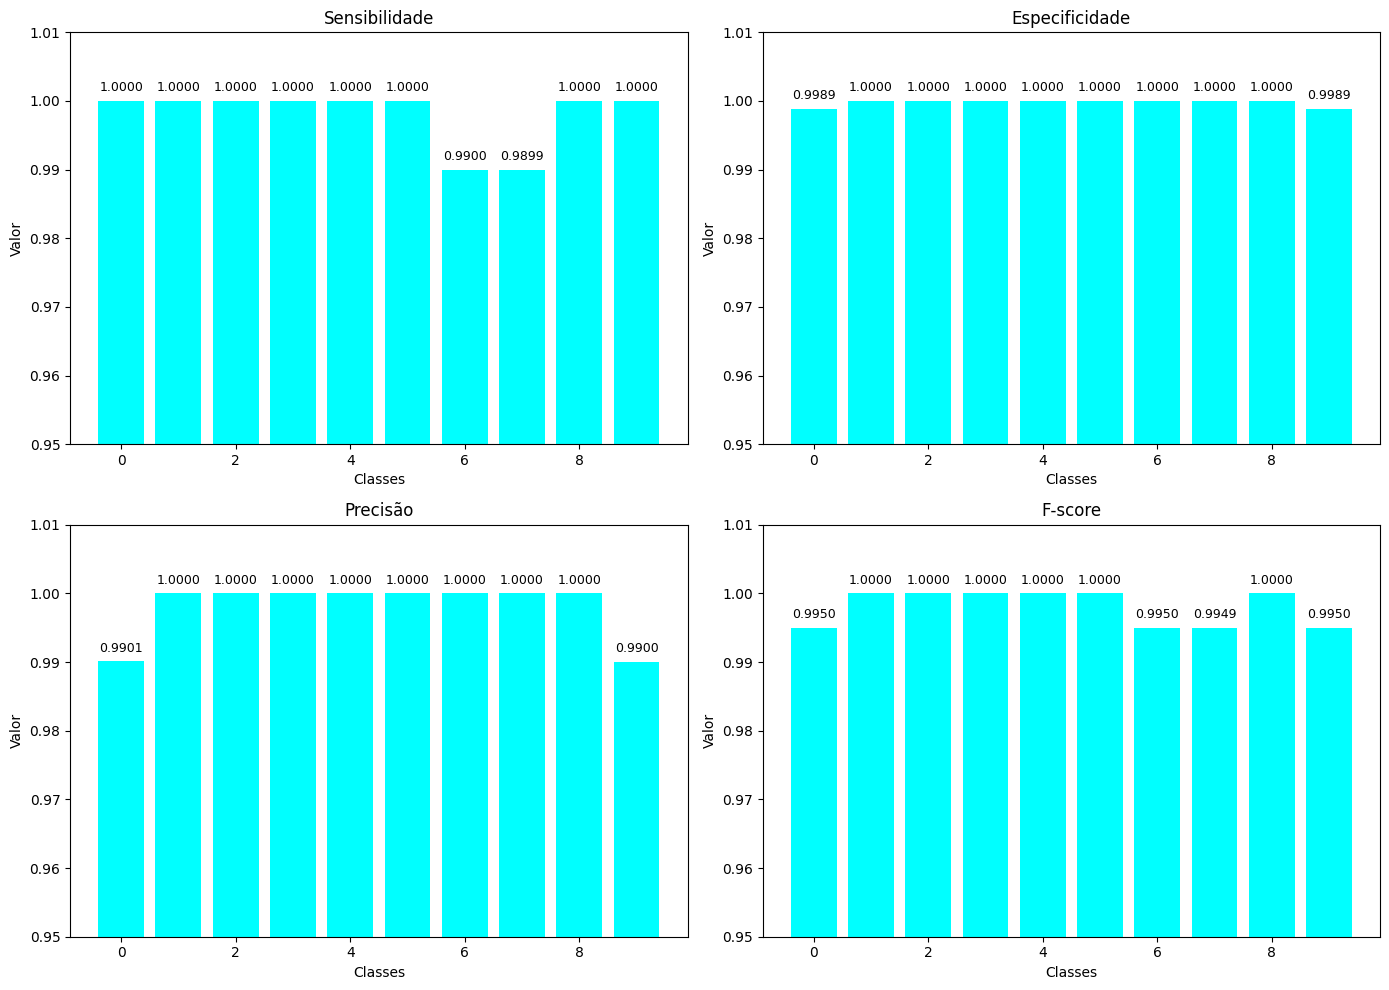

In [19]:
# Criando gráficos separados para cada métrica
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

metric_names = ["Sensibilidade", "Especificidade", "Precisão", "F-score"]
metric_values = [sensibilidade, especificidade, precisao, f_score]

for i, ax in enumerate(axes):
    ax.bar(classes, metric_values[i], color='aqua')
    ax.set_title(metric_names[i])
    ax.set_xlabel("Classes")
    ax.set_ylabel("Valor")
    ax.set_ylim(0.95, 1.01)  # Ajustando o intervalo do eixo Y para maior clareza
    for j, value in enumerate(metric_values[i]):
        ax.text(j, value + 0.001, f"{value:.4f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()